In [278]:
import numpy as np
import numpy.lib.stride_tricks as slide
from scipy.ndimage.interpolation import shift
import math
import proj1 as filters

def toBoolean(input, threshold=10):
    return (1 - (input > threshold)).astype(np.byte)

def makeBooleanDisc(diameter):
    if diameter % 2 != 1:
        raise Error("diameter must be odd")
        
    radius = diameter // 2
    y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
    mask = x**2+y**2 <= radius**2
    return mask.astype(np.byte)


impSobelX = np.asarray([
    [-3, 0, 3],
    [-10, 0, 10],
    [-3, 0, 3]
])
impSobelY = np.asarray([
    [-3, -10, -3],
    [0, 0, 0],
    [3, 10, 3]
])

def improvedSobel(input):
    slid = filters.slideKernel(input, impSobelX)*(1.0/32.0)
    edgeX = np.sum(np.sum(slid, axis=3), axis=2)
    slid = filters.slideKernel(input, impSobelY)*(1.0/32.0)
    edgeY = np.sum(np.sum(slid, axis=3), axis=2)

    return np.sqrt(edgeX ** 2 + edgeY **2)
    
    

def improvedSobelWithTheta(input):
    slid = filters.slideKernel(input, impSobelX)*(1.0/32.0)
    edgeX = np.sum(np.sum(slid, axis=3), axis=2)
    slid = filters.slideKernel(input, impSobelY)*(1.0/32.0)
    edgeY = np.sum(np.sum(slid, axis=3), axis=2)

    edge = np.sqrt(edgeX ** 2 + edgeY **2)
    theta = np.arctan(edgeY / (edgeX + 0.00001))
    return edge, theta



roberts1 = np.asarray([[1, 0], [0, -1]])
roberts2 = np.asarray([[0, 1], [-1, 0]])
def robertsEdge(input):
    slid = filters.slideKernel(input, roberts1)
    edgeX = np.sum(np.sum(slid, axis=3), axis=2)
    slid = filters.slideKernel(input, roberts2)
    edgeY = np.sum(np.sum(slid, axis=3), axis=2)
    edge = np.sqrt(edgeX ** 2 + edgeY **2)
    return edge
    
    
def robertsEdgeWithTheta(input):
    slid = filters.slideKernel(input, roberts1)
    edgeX = np.sum(np.sum(slid, axis=3), axis=2)
    slid = filters.slideKernel(input, roberts2)
    edgeY = np.sum(np.sum(slid, axis=3), axis=2)
    edge = np.sqrt(edgeX ** 2 + edgeY **2)
    theta = np.arctan(edgeY / (edgeX + 0.00001)) - 3*math.pi/4
    return edge, theta


compass0 = np.asarray([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])
compass1 = np.asarray([
    [-2, -1, 0],
    [-1, 0, 1],
    [0, 1, 2]])
compass2 = np.asarray([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]])
compass3 = np.asarray([
    [0, -1,-2],
    [1, 0, -1],
    [2, 1, 0]])


compasses = [compass0, compass1, compass2, compass3, -compass0, -compass1, -compass2, -compass3]

def compassEdge(input):
    compassValues = [np.sum(np.sum(filters.slideKernel(input, compass), axis=3), axis=2) for compass in compasses]
    max = np.maximum(compassValues[0], compassValues[1])
    for i in range(2,8):
        max = np.maximum(max, compassValues[i])
    return max


def dilate(input, mask):
    offsets = np.asarray(mask.shape) // 2
    shifted = [mask[u,v] * shift(input, (u - offsets[0],v - offsets[1])) for v,y in enumerate(mask) for u,x in enumerate(y)]
    return np.logical_or.reduce(shifted).astype(np.byte)
    

def erode(input, mask, mode='edge'):
    slide = filters.slideKernel(input, mask, mode)
    return (np.sum(np.sum(slide, axis=3), axis=2) == np.sum(mask)).astype(np.byte)

def growAndShrink(input, mask, steps=1):
    morph = input
    for _ in range(steps):
        morph = dilate(morph, mask)
    for _ in range(steps):
        morph = erode(morph, mask)
    return morph


def shrinkAndGrow(input, mask, steps=1):
    morph = input
    for _ in range(steps):
        morph = erode(morph, mask)
    for _ in range(steps):
        morph = dilate(morph, mask)
    return morph

def thresholdSegmentation(input, threshold):
    return (input <= threshold).astype(np.byte)

def calcGroupVariance(input, threshold):
    segmented = (input <= threshold).astype(np.byte)
    
    objProbability = np.count_nonzero(segmented) / input.size
    
    if objProbability == 0:
        objVariance = 0
    else:
        objVariance = np.var(input, where = segmented == 1)
        
    if objProbability == 1:
        bakVariance = 0
    else:
        bakVariance = np.var(input, where = segmented == 0)
    
    return objProbability * objVariance + (1 - objProbability) * bakVariance
    
    

def findBestSegmentationThreshold(input, stepSize = 10):
    thresholds = range(stepSize, 255, stepSize)
    variances = [calcGroupVariance(input, threshold) for threshold in thresholds]
    return thresholds[np.argmin(variances)]
    
    
def autoThresholdSegmentation(input, searchStepSize = 10):
    return thresholdSegmentation(input, findBestSegmentationThreshold(input, searchStepSize))
    
    
def kMeansSegmentation(img, k):
    imgSet = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    indices = [[x,y] for x in range(img.shape[0]) for y in range(img.shape[1])]
    #data = np.append(imgSet, indices, axis=1)
    data = imgSet
    vectorLength = data.shape[1]
    
    kPoints = np.asarray([
        [np.random.randint(0, 255) for _ in range(] for _ in range(k)])
    
    oldPoints = np.zeros(kPoints.shape)


    while not np.all(oldPoints == kPoints):
        assignments = np.argmin(np.linalg.norm(np.repeat(np.reshape(data, (data.shape[0], 1, vectorLength)), k, axis=1) - kPoints, axis=2), axis=1)
        ass = np.repeat(np.reshape(assignments, (data.shape[0], 1)), vectorLength, axis=1)
        oldPoints = kPoints
        kPoints = np.round([np.mean(data, where = ass == kIndex * np.ones(vectorLength), axis=0) for kIndex in range(k)]).astype(int)

    
    return np.asarray(np.split(assignments, img.shape[0]))




C:\Users\Gwahi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\core\fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Gwahi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


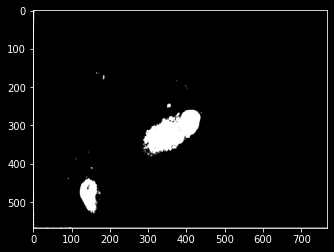

In [286]:
import imageio as iio
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
from scipy.special import softmax

plt.style.use('dark_background')

img = iio.imread('./images/cyl01.BMP')
gimg = np.zeros(img.shape[0:2], dtype=img.dtype)
buffer = np.zeros(img.shape[0:2], dtype=img.dtype)
filters.rgbToLuminosity(img, gimg)


test = [[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]]
mask = makeBooleanDisc(3)

def colorizeSegmentation(segmented, colorCount):
    colors = np.arange(0, 255.0, 255.0/7).astype(np.byte)
    return np.choose(segmented, colors)



#plt.figure()
#plt.imshow(img, cmap='gray')



plt.figure()
plt.imshow(colorizeSegmentation(kMeansSegmentation(img, 3),3), cmap='gray')

